In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

# Loading maps

In [2]:
import mapping.utils as maps
import matplotlib.pyplot as plt

In [3]:
FILE = './data/file150.json' # Sample file

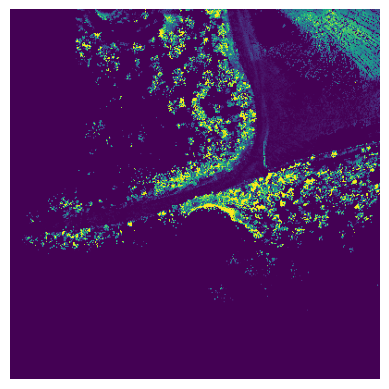

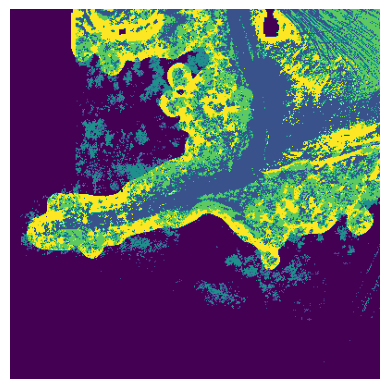

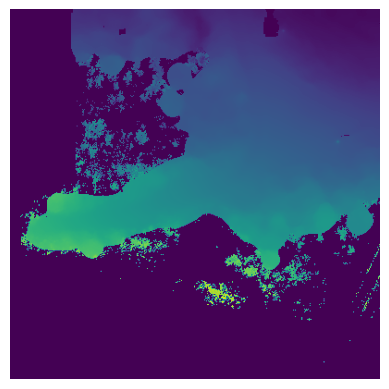

In [4]:
object_map, observed_map, terrain_map, origin_x, origin_y, resolution, num_x, num_y = maps.load_layers(FILE)

plt.imshow(object_map, origin ='lower')
plt.axis('off')
#plt.savefig("assets/object_map-150.png", bbox_inches='tight')
plt.show()

plt.imshow(observed_map, origin ='lower')
plt.axis('off')
#plt.savefig("assets/observed_map-150.png", bbox_inches='tight')
plt.show()

plt.imshow(terrain_map, origin ='lower')
plt.axis('off')
#plt.savefig("assets/terrain_map-150.png", bbox_inches='tight')
plt.show()

## Finding a path with a Rapidly-exploring Random Tree (RRT)

In [5]:
import sys
from pathlib import Path

PATH_TO_SHARED_LIB = str(Path("").resolve()) + "/rrt_sharp/src/rrt_sharp/build/"
sys.path.append(PATH_TO_SHARED_LIB)

from rrt_sharp_py import *

In [6]:
version = 1

In [25]:
# Configure RRTSharp object

# Create Map dimension
rrt_sharp = RRTSharp([2, 3, 4])

rrt_sharp.set_map_info(origin_x, origin_y, resolution, num_x, num_y)
rrt_sharp.set_object_map(object_map.flatten().tolist())
rrt_sharp.set_observed_map(observed_map.astype(int).flatten().tolist())
rrt_sharp.set_terrain_map(terrain_map.flatten().tolist())
rrt_sharp.set_start_state(227.0, -143.0, 180.0)
rrt_sharp.set_goal_state(114.0, -250.0, 300.0)
rrt_sharp.set_stop_radius(5.0)

# Run RRT

rrt_sharp.init()
rrt_sharp.run()

Reached
Reached
Reached
Reached
Reached
Reached
Reached
numNodes: 4261, numChildren: 4261
total: 1102.46 ms


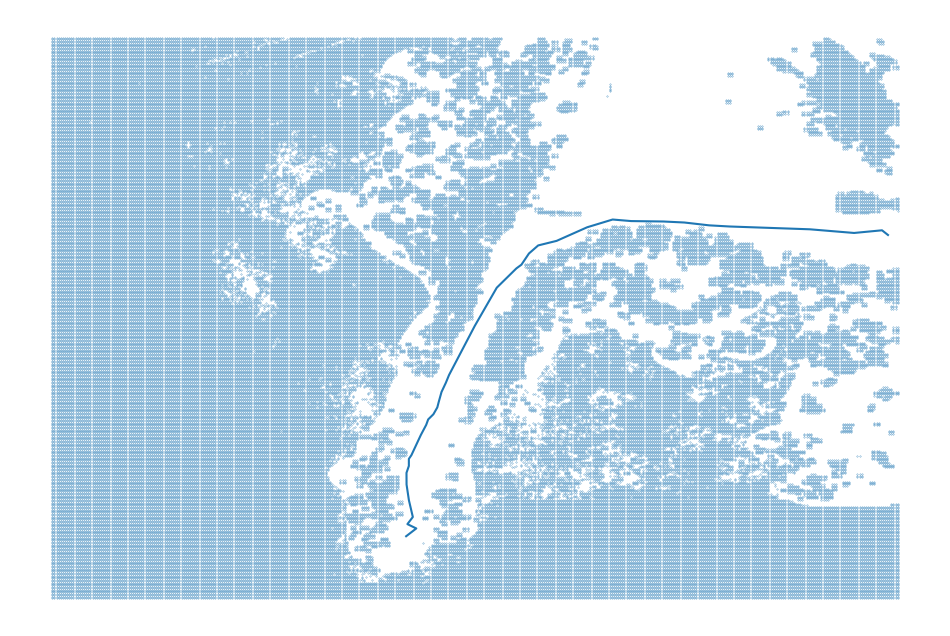

In [26]:
traj_x = np.array(list(rrt_sharp.get_trajectory_x()))
traj_y = np.array(list(rrt_sharp.get_trajectory_y()))

search_space_x = list(rrt_sharp.get_search_space_x())
search_space_y = list(rrt_sharp.get_search_space_y())

fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(traj_x, traj_y)

plt.axis('off')
#plt.savefig(f"assets/iLQR/rrt-150-{version}.png", bbox_inches='tight')
plt.show()

# Simulating dynamics

In [27]:
import optimization.bicycle_model as bicycle_model
from optimization.utils import *
import optimization.quadratic as qr

## Simple example

In [28]:
model = bicycle_model.BicycleModelParameters(dt=0.2, max_steering_angle=3, min_steering_angle=-3, wheelbase=1)

# state: x, y, yaw, velocity

nx = 4
x0 = np.array([0, 0, 0, 0.2]) # initial state

# controls: acceleration, steering_angle

nu = 2
U = np.array([[2, 0], [1.2, 0.3], [1.4, 0.4], [0, 0.2]])

N = U.shape[0]+1

# Simulate dynamics

params = OptimizationParameters(nx=nx, nu=nu, N=N, model=model)

# Caution: no constraints on the controls are handled by the forward pass/dynamics
X = simulate(x0, U, bicycle_model.discrete_dynamics, params)

print(X)

[[0.         0.         0.         0.2       ]
 [0.08       0.         0.         0.6       ]
 [0.2239752  0.00267251 0.04454442 0.84      ]
 [0.41934741 0.01834733 0.12741189 1.12      ]
 [0.64082826 0.05184703 0.17281894 1.12      ]]


## Using iLQR to follow reference trajectory

Now, we need to convert `traj_x` and `traj_y` from RRT to corresponding `Xref` and `Uref` with correct sizes

In [29]:
points = np.dstack((traj_x, traj_y)).squeeze()
distances = np.linalg.norm(points[1:] - points[:-1], axis=1)
min_dist = distances.min()
print(min_dist)
print(distances.max())

1.4648641780042462
18.999823019037724


In [30]:
#traj_x, traj_y, N = upsample(traj_x, traj_y, 512)
traj_x, traj_y, N = linspace(traj_x, traj_y, min_dist)

In [31]:
# create reference trajectory 
Xref, Uref = np.array([traj_x, traj_y, np.zeros(N), 4.5*np.ones(N)]).T, np.zeros((N-1, nu))

angles = []

# Guess yaw angles
for k in range(len(Xref) - 1):
    p1 = Xref[k]
    p2 = Xref[k+1]
    angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0]) # tan^-1(Δy/Δx)
    angle = angle if angle > 0 else angle + 2*np.pi
    angles.append(angle)
angles.append(angles[-1])
    
last_angle = angles[0]
for k in range(len(Xref)):
    angle = angles[k]
    Xref[k, 2] = (last_angle + angle)/2 # average of yaw angles
    #Xref[k, 2] = angle
    last_angle = angle

for k in range(len(Xref) - 1):
    # estimating the steering angle very roughly
    diff_angles = Xref[k+1, 2] - Xref[k, 2]
    Uref[k, 1] = diff_angles
#Uref[-80:, 0] = 160
#Uref[-50:, 0] = -140

[[ 227.7024     -142.6808        2.26944495    4.5       ]
 [ 226.999      -141.8434        2.26944495    4.5       ]
 [ 226.2956     -141.006         2.77690999    4.5       ]
 [ 225.19589956 -141.16409364    3.28437503    4.5       ]
 [ 224.09619911 -141.32218729    3.28437503    4.5       ]]
[[ 0.00000000e+00  9.76996262e-15]
 [ 0.00000000e+00  5.07465039e-01]
 [ 0.00000000e+00  5.07465039e-01]
 [ 0.00000000e+00 -1.77635684e-15]
 [ 0.00000000e+00  1.24344979e-14]]


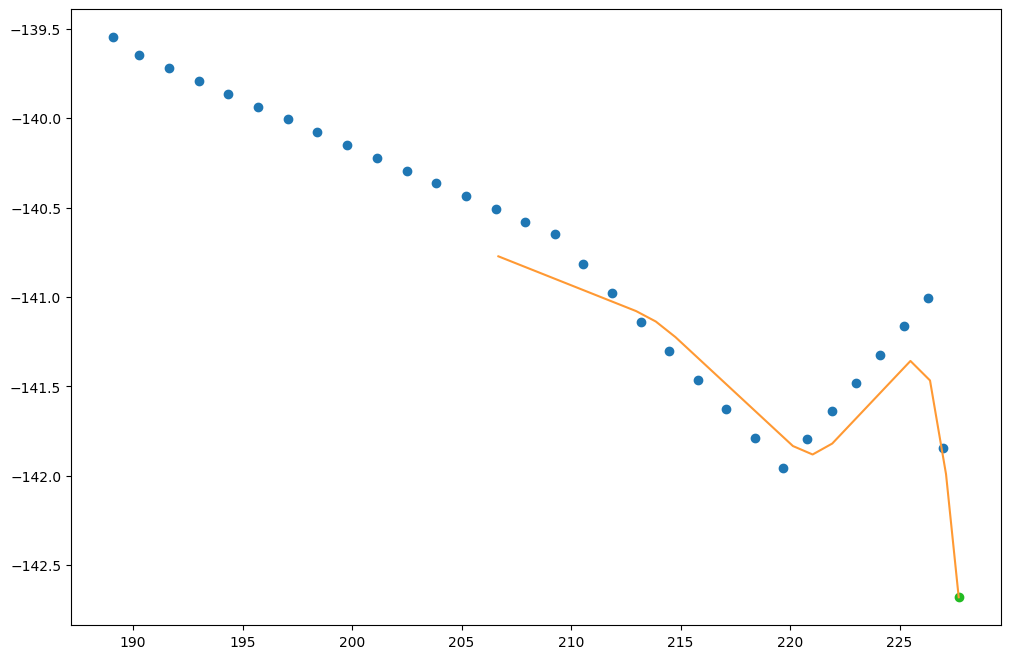

In [32]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(Xref[1:32, 0], Xref[1:32, 1])
plt.scatter(Xref[0, 0], Xref[0, 1], c="#22BB22")

print(Xref[0:5])
print(Uref[0:5])

params.N = Uref.shape[0]+1
X = simulate(Xref[0], Uref, bicycle_model.discrete_dynamics, params)

plt.plot(X[0:25, 0], X[0:25, 1], c="#FF9933")

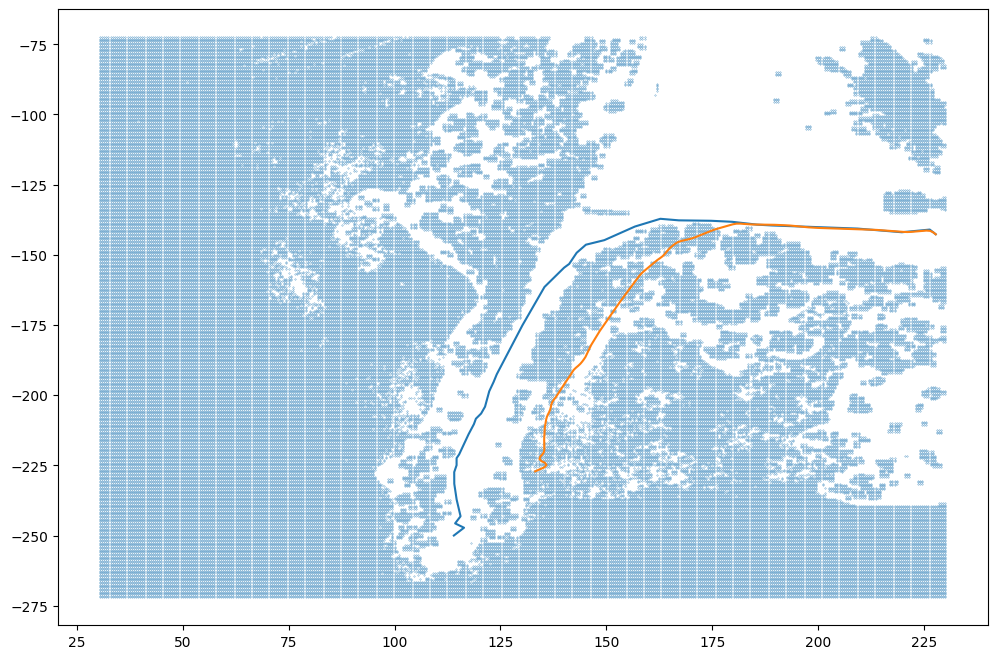

In [33]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

params.N = Uref.shape[0]+1
X = simulate(Xref[0], Uref, bicycle_model.discrete_dynamics, params)

Xref[:, 3] = X[:, 3] # update velocities with more accurate ones

plt.plot(Xref[:, 0], Xref[:, 1])
plt.plot(X[:, 0], X[:, 1])
#plt.savefig(f"assets/iLQR/guess-150-{version}.png", bbox_inches='tight')
plt.show()

Xref length: 173
Uref length: 172
 
Optimizing chunk 0
X: 0-59
U: 0-58
iLQR converged in 3 iteration(s)
 
Optimizing chunk 1
X: 59-119
U: 59-118
iLQR converged in 4 iteration(s)
 
Optimizing chunk 2
X: 119-179
U: 119-178
iLQR converged in 4 iteration(s)
Optimization done


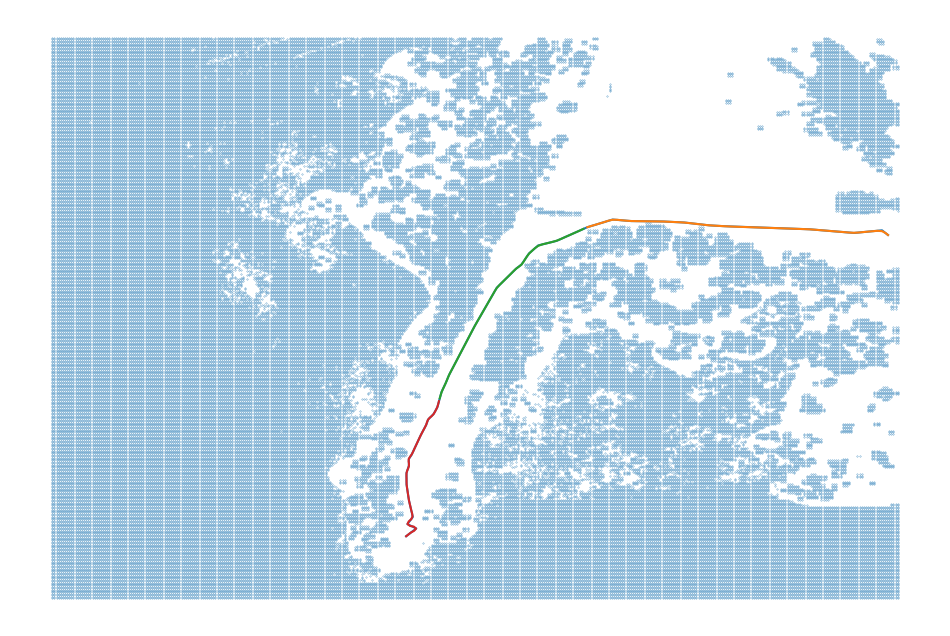

In [34]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ion() # enable interactivity

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(Xref[:, 0], Xref[:, 1])

plt.axis('off')
#plt.savefig(f"assets/iLQR/iLQR-150-{version}.png", bbox_inches='tight')
#plt.show()

# problem size 
dt = model.dt

# tracking cost function
Q = np.diag([4, 4, 0.5, 0.1])
R = np.diag([0.1, 0.2])
Qf = 10*Q

arrX = []
arrU = []
arrK = []

print(f"Xref length: {len(Xref)}")
print(f"Uref length: {len(Uref)}")

chunk = 60
i = 0
while (i*chunk) < len(Xref):
    print(" ")
    print(f"Optimizing chunk {i}")
    
    print(f"X: {chunk*i if i==0 else chunk*i-1}-{chunk*(i+1)-1}")
    print(f"U: {chunk*i if i==0 else chunk*i-1}-{chunk*(i+1)-1-1}")
    
    subX = Xref[chunk*i:chunk*(i+1)]
    subU = Uref[chunk*i if i==0 else chunk*i-1:chunk*(i+1)-1]
    
    if i > 0:
        x0 = np.array([arrX[-1][-1]])
        subX = np.vstack((x0, subX)) # append last of previous chunk

    # the params needed by iLQR 
    qrParams = qr.QR(
        Q=Q,
        Qf=Qf,
        R=R,
        Xref=subX,
        Uref=subU,
        nx=params.nx,
        nu=params.nu,
        N=len(subX),
        model=params.model
    )

    # initial condition 
    x0 = subX[0]

    # initial guess controls 
    U = subU
    U[:, 0] += 1e-10*np.random.normal(size=subU.shape[0]) # for controllability

    X = subX
    
    # solve with iLQR
    Xi, Ui, Ki = qr.iLQR(x0, U, bicycle_model.discrete_dynamics, bicycle_model.discrete_dynamics_grad, qrParams)
    
    if i > 0:
        Xi = Xi[1:] # remove first element to avoid duplicates
    
    arrX.append(Xi)
    arrU.append(Ui)
    arrK.append(Ki)
    
    plt.plot(Xi[:, 0], Xi[:, 1])
    
    i += 1
    
print("Optimization done")

In [35]:
X = np.array([ptx for subarr in arrX for ptx in subarr])
U = np.array([ptu for subarr in arrU for ptu in subarr])
K = np.array([ptk for subarr in arrK for ptk in subarr])

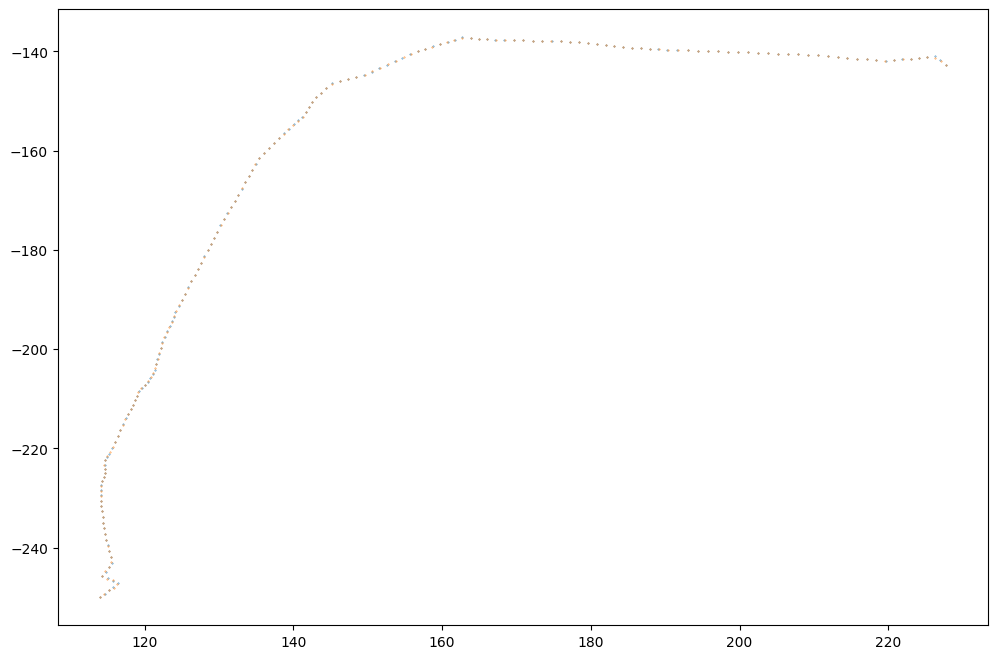

In [36]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.scatter(Xref[:, 0], Xref[:, 1], s=0.1)
plt.scatter(X[:, 0], X[:, 1], s=0.1)

In [37]:
print(X.shape)
print(U.shape)

(173, 4)
(172, 2)


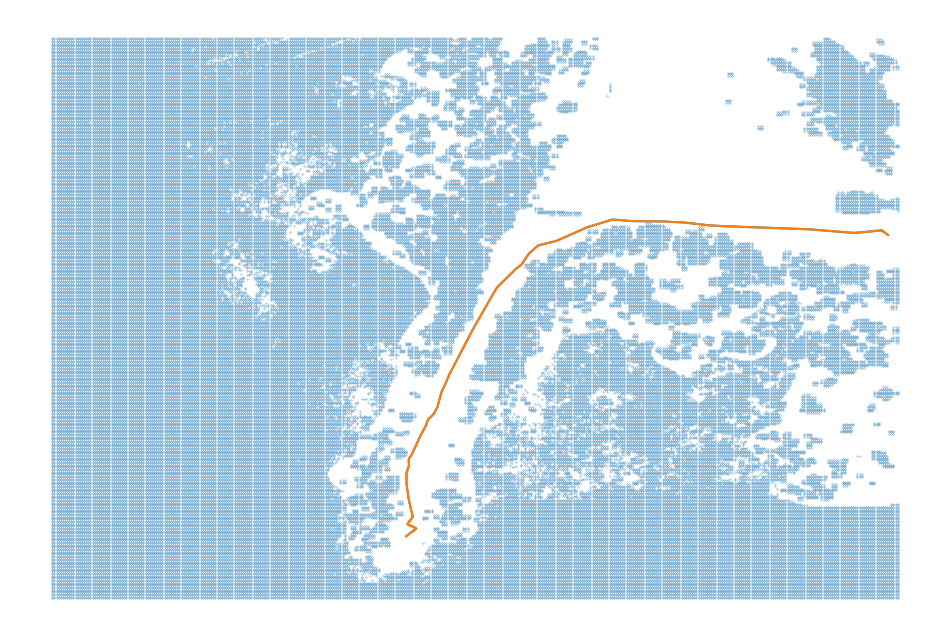

In [38]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(Xref[:, 0], Xref[:, 1])
#plt.plot(X[:, 0], X[:, 1])

params.N = len(X)
Xsim = simulate(X[0], U, bicycle_model.discrete_dynamics, params)
plt.plot(Xsim[:, 0], Xsim[:, 1])

plt.axis('off')
plt.savefig(f"assets/iLQR/iLQR-by-part-150-{version}.png", bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Acceleration')

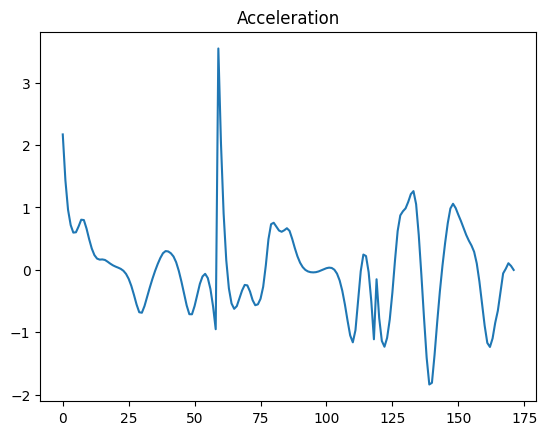

In [39]:
plt.plot(U[:, 0])
plt.title("Acceleration")

Text(0.5, 1.0, 'Steering angle')

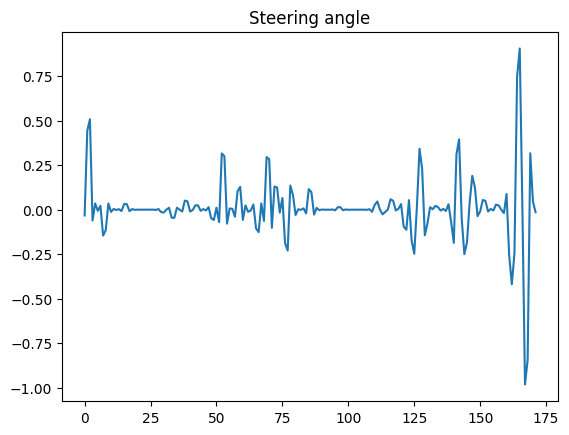

In [40]:
plt.plot(U[:, 1])
plt.title("Steering angle")

Text(0.5, 1.0, 'Yaw angle')

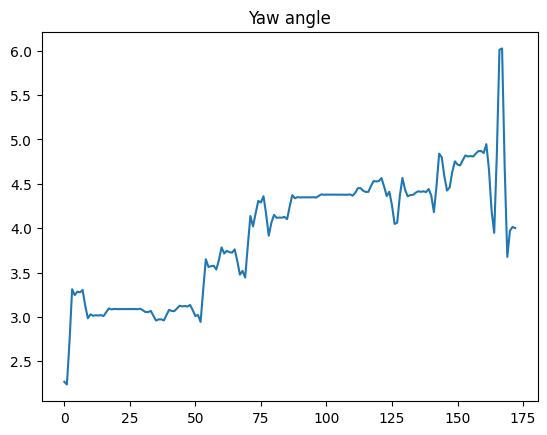

In [41]:
plt.plot(X[:, 2])
plt.title("Yaw angle")

Text(0.5, 1.0, 'Velocity')

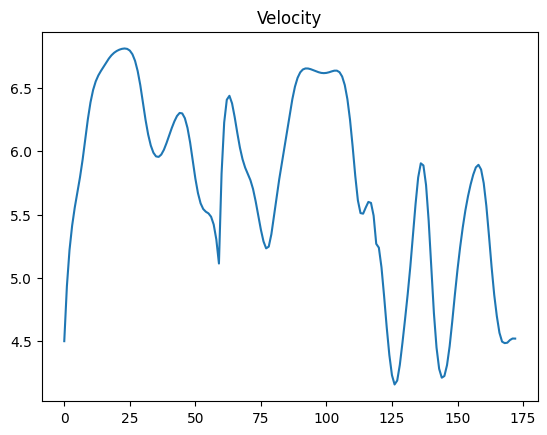

In [42]:
plt.plot(X[:, 3])
plt.title("Velocity")